# Baseline Routing Heuristics

## All to biggest LLM (Flan-T5-XL)

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Configuration
exclude_percentile = 80  # Exclude top X% most complex queries
train_ratio = 0.90       # 90% Training, 10% Testing

# Load dataset
df = pd.read_json(
    '../../datasets/generated/step_13/train_data_with_query_and_response_features_discrepancies_with_scores_model_label_dt0_tt3_rt3.jsonl',
    orient='records', lines=True
)

# Determine complexity threshold
complexity_threshold = df['query_complexity_score'].quantile(exclude_percentile / 100)

# Filter out the top X% most complex queries
filtered_df = df[df['query_complexity_score'] <= complexity_threshold].copy()
num_removed = len(df) - len(filtered_df)

print(f"Filtered out the top {100 - exclude_percentile}% most complex queries.")
print(f"Total queries removed: {num_removed}. Remaining for training/testing: {len(filtered_df)}.")

# Compute dynamic train-test split
num_train = round(len(filtered_df) * train_ratio)  # First 90% for training
num_test = len(filtered_df) - num_train            # Remaining 10% for testing

train_df = filtered_df.iloc[:num_train].copy()     # Train set (first 90%)
test_df = filtered_df.iloc[num_train:].copy()      # Test set (remaining 10%)

print(f"Final split: {num_train} queries for training, {num_test} queries for testing.")

# Apply the baseline router: Always choose XL (3)
start_time = time.time()
test_df['routed_to'] = 3  # Assign model 3 (XL) to all queries
end_time = time.time()
routing_time = end_time - start_time
avg_query_routing_time = routing_time / len(test_df)

# Count queries routed to each model
num_routed_base = (test_df['routed_to'] == 1).sum()
num_routed_large = (test_df['routed_to'] == 2).sum()
num_routed_xl = (test_df['routed_to'] == 3).sum()

print(f"Routing Completed in {routing_time:.4f} seconds.")
print(f"Avg Routing Time per Query: {avg_query_routing_time:.8f} seconds.")
print(f"Number of queries routed to Base: {num_routed_base}")
print(f"Number of queries routed to Large: {num_routed_large}")
print(f"Number of queries routed to XL: {num_routed_xl}")

# Define accuracy
accuracy = accuracy_score(test_df['evaluation_model_label'], test_df['routed_to']) * 100

def calculate_quality_discrepancies(df):
    """
    Calculates the quality loss compared to the ground truth (GT) and XL model.

    Args:
        df (pd.DataFrame): The test dataset containing query results and model labels.

    Returns:
        tuple: (quality_loss_to_gt, quality_loss_to_xl)
    """
    total_score_gt = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['evaluation_model_label'] - 1]}"], axis=1).sum()
    total_score_router = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['routed_to'] - 1]}"], axis=1).sum()
    total_score_xl = df['avg_normalized_score_t5_xl'].sum()

    num_queries = len(df)

    avg_score_gt = total_score_gt / num_queries
    avg_score_router = total_score_router / num_queries
    avg_score_xl = total_score_xl / num_queries

    quality_loss_to_gt = ((avg_score_router - avg_score_gt) / avg_score_gt) * 100
    quality_loss_to_xl = ((avg_score_router - avg_score_xl) / avg_score_xl) * 100

    return quality_loss_to_gt, quality_loss_to_xl

quality_loss_gt, quality_loss_xl = calculate_quality_discrepancies(test_df)

# Define compute savings
COMPUTE_UNITS = {1: 1.0, 2: 3.12, 3: 12.0}
compute_units_gt = sum(test_df['evaluation_model_label'].map(COMPUTE_UNITS))  # GT model compute usage
compute_units_xl = len(test_df) * COMPUTE_UNITS[3]  # XL model compute usage
compute_savings_gt = ((compute_units_gt - compute_units_xl) / compute_units_gt) * 100
compute_savings_xl = ((compute_units_xl - compute_units_xl) / compute_units_xl) * 100

# Print final evaluation metrics
print("\n--- Baseline Router Evaluation (Always Route to XL) ---")
print(f"Quality Loss compared to GT: {quality_loss_gt:.2f}%")
print(f"Quality Loss compared to XL: {quality_loss_xl:.2f}%")
print(f"Compute Savings compared to GT: {compute_savings_gt:.2f}%")
print(f"Compute Savings compared to XL: {compute_savings_xl:.2f}%")
print(f"Routing Accuracy: {accuracy:.2f}%")
print(f"Total Compute Units Used: {compute_units_xl:.2f} CUs")


Filtered out the top 20% most complex queries.
Total queries removed: 9996. Remaining for training/testing: 40004.
Final split: 36004 queries for training, 4000 queries for testing.
Routing Completed in 0.0007 seconds.
Avg Routing Time per Query: 0.00000017 seconds.
Number of queries routed to Base: 0
Number of queries routed to Large: 0
Number of queries routed to XL: 4000

--- Baseline Router Evaluation (Always Route to XL) ---
Quality Loss compared to GT: -2.92%
Quality Loss compared to XL: 0.00%
Compute Savings compared to GT: -36.24%
Compute Savings compared to XL: 0.00%
Routing Accuracy: 67.35%
Total Compute Units Used: 48000.00 CUs


## All to smallest LLM (BASE)

In [2]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Configuration
exclude_percentile = 80  # Exclude top X% most complex queries
train_ratio = 0.90       # 90% Training, 10% Testing

# Load dataset
df = pd.read_json(
    '../../datasets/generated/step_13/train_data_with_query_and_response_features_discrepancies_with_scores_model_label_dt0_tt3_rt3.jsonl',
    orient='records', lines=True
)

# Determine complexity threshold
complexity_threshold = df['query_complexity_score'].quantile(exclude_percentile / 100)

# Filter out the top X% most complex queries
filtered_df = df[df['query_complexity_score'] <= complexity_threshold].copy()
num_removed = len(df) - len(filtered_df)

print(f"Filtered out the top {100 - exclude_percentile}% most complex queries.")
print(f"Total queries removed: {num_removed}. Remaining for training/testing: {len(filtered_df)}.")

# Compute dynamic train-test split
num_train = round(len(filtered_df) * train_ratio)  # First 90% for training
num_test = len(filtered_df) - num_train            # Remaining 10% for testing

train_df = filtered_df.iloc[:num_train].copy()     # Train set (first 90%)
test_df = filtered_df.iloc[num_train:].copy()      # Test set (remaining 10%)

print(f"Final split: {num_train} queries for training, {num_test} queries for testing.")

# Apply the baseline router: Always choose BASE (1)
start_time = time.time()
test_df['routed_to'] = 1
end_time = time.time()
routing_time = end_time - start_time
avg_query_routing_time = routing_time / len(test_df)

# Count queries routed to each model
num_routed_base = (test_df['routed_to'] == 1).sum()
num_routed_large = (test_df['routed_to'] == 2).sum()
num_routed_xl = (test_df['routed_to'] == 3).sum()

print(f"Routing Completed in {routing_time:.4f} seconds.")
print(f"Avg Routing Time per Query: {avg_query_routing_time:.8f} seconds.")
print(f"Number of queries routed to Base: {num_routed_base}")
print(f"Number of queries routed to Large: {num_routed_large}")
print(f"Number of queries routed to XL: {num_routed_xl}")

# Define accuracy
accuracy = accuracy_score(test_df['evaluation_model_label'], test_df['routed_to']) * 100  # Convert to %

def calculate_quality_discrepancies(df):
    """
    Calculates the quality loss compared to the ground truth (GT) and XL model.

    Args:
        df (pd.DataFrame): The test dataset containing query results and model labels.

    Returns:
        tuple: (quality_loss_to_gt, quality_loss_to_xl)
    """
    total_score_gt = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['evaluation_model_label'] - 1]}"], axis=1).sum()
    total_score_router = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['routed_to'] - 1]}"], axis=1).sum()
    total_score_xl = df['avg_normalized_score_t5_xl'].sum()

    num_queries = len(df)

    avg_score_gt = total_score_gt / num_queries
    avg_score_router = total_score_router / num_queries
    avg_score_xl = total_score_xl / num_queries

    quality_loss_to_gt = ((avg_score_router - avg_score_gt) / avg_score_gt) * 100
    quality_loss_to_xl = ((avg_score_router - avg_score_xl) / avg_score_xl) * 100

    return quality_loss_to_gt, quality_loss_to_xl

quality_loss_gt, quality_loss_xl = calculate_quality_discrepancies(test_df)

# Define compute savings
COMPUTE_UNITS = {1: 1.0, 2: 3.12, 3: 12.0}
compute_units_gt = sum(test_df['evaluation_model_label'].map(COMPUTE_UNITS))  # GT model compute usage
compute_units_base = len(test_df) * COMPUTE_UNITS[1]  # Base model compute usage
compute_savings_gt = ((compute_units_gt - compute_units_base) / compute_units_gt) * 100
compute_savings_xl = ((COMPUTE_UNITS[3] * len(test_df) - compute_units_base) / (COMPUTE_UNITS[3] * len(test_df))) * 100

# Print final evaluation metrics
print("\n--- Baseline Router Evaluation (Always Route to Base) ---")
print(f"Quality Loss compared to GT: {quality_loss_gt:.2f}%")
print(f"Quality Loss compared to XL: {quality_loss_xl:.2f}%")
print(f"Compute Savings compared to GT: {compute_savings_gt:.2f}%")
print(f"Compute Savings compared to XL: {compute_savings_xl:.2f}%")
print(f"Routing Accuracy: {accuracy:.2f}%")
print(f"Total Compute Units Used: {compute_units_base:.2f} CUs")


Filtered out the top 20% most complex queries.
Total queries removed: 9996. Remaining for training/testing: 40004.
Final split: 36004 queries for training, 4000 queries for testing.
Routing Completed in 0.0010 seconds.
Avg Routing Time per Query: 0.00000024 seconds.
Number of queries routed to Base: 4000
Number of queries routed to Large: 0
Number of queries routed to XL: 0

--- Baseline Router Evaluation (Always Route to Base) ---
Quality Loss compared to GT: -15.92%
Quality Loss compared to XL: -13.40%
Compute Savings compared to GT: 88.65%
Compute Savings compared to XL: 91.67%
Routing Accuracy: 13.80%
Total Compute Units Used: 4000.00 CUs


## Routing queries based on length (chars)

Filtered out the top 20% most complex queries.
Total queries removed: 9996. Remaining for training/testing: 40004.
Final split: 36004 queries for training, 4000 queries for testing.

=== Routing Evaluation for Quantiles (20-40-60) ===
  - Low Complexity (Base)     : <= 51.00 chars
  - Medium Complexity (Large) : > 51.00 and <= 61.00 chars
  - High Complexity (XL)      : > 61.00 chars
Routing Completed in 0.0106 seconds.
Avg Routing Time per Query: 0.00000266 seconds.
Number of queries routed to Base: 846
Number of queries routed to Large: 788
Number of queries routed to XL: 2366

--- Routing Heuristic Evaluation ---
Quality Loss compared to GT: -7.20%
Quality Loss compared to XL: -4.41%
Compute Savings compared to GT: 10.04%
Compute Savings compared to XL: 33.97%
Routing Accuracy: 45.50%
Total Compute Units Used: 31696.56 CUs

=== Routing Evaluation for Quantiles (25-50-75) ===
  - Low Complexity (Base)     : <= 54.00 chars
  - Medium Complexity (Large) : > 54.00 and <= 67.00 chars
  -

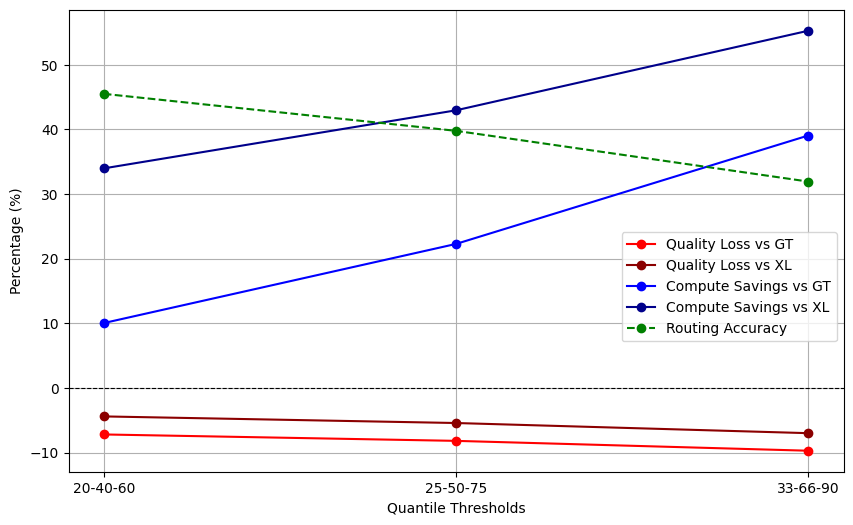

Plot saved in '../../plots/evaluation_length_based_routing.pdf'


In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Configuration
exclude_percentile = 80  # Exclude top X% most complex queries
train_ratio = 0.90       # 90% Training, 10% Testing

# Load dataset
df = pd.read_json(
    '../../datasets/generated/step_13/train_data_with_query_and_response_features_discrepancies_with_scores_model_label_dt0_tt3_rt3.jsonl',
    orient='records', lines=True
)

# Determine complexity threshold
complexity_threshold = df['query_complexity_score'].quantile(exclude_percentile / 100)

# Filter out the top X% most complex queries
filtered_df = df[df['query_complexity_score'] <= complexity_threshold].copy()
num_removed = len(df) - len(filtered_df)

print(f"Filtered out the top {100 - exclude_percentile}% most complex queries.")
print(f"Total queries removed: {num_removed}. Remaining for training/testing: {len(filtered_df)}.")

# Compute dynamic train-test split
num_train = round(len(filtered_df) * train_ratio)  # First 90% for training
num_test = len(filtered_df) - num_train            # Remaining 10% for testing

train_df = filtered_df.iloc[:num_train].copy()     # Train set (first 90%)
test_df = filtered_df.iloc[num_train:].copy()      # Test set (remaining 10%)

print(f"Final split: {num_train} queries for training, {num_test} queries for testing.")

# Define compute unit consumption for each model
COMPUTE_UNITS = {1: 1.0, 2: 3.12, 3: 12.0}

# Define different quantile threshold configurations
quantile_settings = [
    (0.20, 0.40, 0.60),  # 20th, 40th, 60th percentiles
    (0.25, 0.50, 0.75),  # 25th, 50th, 75th percentiles
    (0.33, 0.66, 0.90),  # 33rd, 66th, 90th percentiles
]

def calculate_quality_discrepancies(df):
    """
    Calculates the quality loss compared to the ground truth (GT) and XL model.

    Args:
        df (pd.DataFrame): The test dataset containing query results and model labels.

    Returns:
        tuple: (quality_loss_to_gt, quality_loss_to_xl)
    """
    total_score_gt = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['evaluation_model_label'] - 1]}"], axis=1).sum()
    total_score_router = df.apply(lambda row: row[f"avg_normalized_score_t5_{['base', 'large', 'xl'][row['routed_to'] - 1]}"], axis=1).sum()
    total_score_xl = df['avg_normalized_score_t5_xl'].sum()

    num_queries = len(df)

    avg_score_gt = total_score_gt / num_queries
    avg_score_router = total_score_router / num_queries
    avg_score_xl = total_score_xl / num_queries

    quality_loss_to_gt = ((avg_score_router - avg_score_gt) / avg_score_gt) * 100
    quality_loss_to_xl = ((avg_score_router - avg_score_xl) / avg_score_xl) * 100

    return quality_loss_to_gt, quality_loss_to_xl

# Lists for visualization
quality_loss_gt_list = []
quality_loss_xl_list = []
compute_savings_gt_list = []
compute_savings_xl_list = []
accuracy_list = []
quantile_labels = ["20-40-60", "25-50-75", "33-66-90"]

# Iterate over quantile settings
for low_q, mid_q, high_q in quantile_settings:
    # Compute thresholds
    low_threshold = test_df['query_chars_count'].quantile(low_q)
    high_threshold = test_df['query_chars_count'].quantile(mid_q)

    print(f"\n=== Routing Evaluation for Quantiles ({int(low_q*100)}-{int(mid_q*100)}-{int(high_q*100)}) ===")
    print(f"  - Low Complexity (Base)     : <= {low_threshold:.2f} chars")
    print(f"  - Medium Complexity (Large) : > {low_threshold:.2f} and <= {high_threshold:.2f} chars")
    print(f"  - High Complexity (XL)      : > {high_threshold:.2f} chars")

    def route_by_quantile(char_count):
        """
        Routes queries based on predefined quantile thresholds for character count.

        Args:
            char_count (int): Character count of the query.

        Returns:
            int: Model assignment (1 = Base, 2 = Large, 3 = XL).
        """
        if char_count > high_threshold:
            return 3  # Route to XL
        elif char_count > low_threshold:
            return 2  # Route to Large
        else:
            return 1  # Route to Base

    # Apply routing
    start_time = time.time()
    test_df['routed_to'] = test_df['query_chars_count'].apply(route_by_quantile)
    end_time = time.time()
    routing_time = end_time - start_time
    avg_query_routing_time = routing_time / len(test_df)
    
    # Count queries routed to each model
    num_routed_base = (test_df['routed_to'] == 1).sum()
    num_routed_large = (test_df['routed_to'] == 2).sum()
    num_routed_xl = (test_df['routed_to'] == 3).sum()

    print(f"Routing Completed in {routing_time:.4f} seconds.")
    print(f"Avg Routing Time per Query: {avg_query_routing_time:.8f} seconds.")
    print(f"Number of queries routed to Base: {num_routed_base}")
    print(f"Number of queries routed to Large: {num_routed_large}")
    print(f"Number of queries routed to XL: {num_routed_xl}")

    # Define accuracy
    accuracy = accuracy_score(test_df['evaluation_model_label'], test_df['routed_to']) * 100  # Convert to %

    # Compute quality discrepancies
    quality_loss_gt, quality_loss_xl = calculate_quality_discrepancies(test_df)

    # Define compute usage and savings
    compute_units_gt = sum(test_df['evaluation_model_label'].map(COMPUTE_UNITS))  # GT model compute usage
    compute_units_router = sum(test_df['routed_to'].map(COMPUTE_UNITS))  # Router model compute usage
    compute_units_xl = len(test_df) * COMPUTE_UNITS[3]  # XL model compute usage

    compute_savings_gt = ((compute_units_gt - compute_units_router) / compute_units_gt) * 100
    compute_savings_xl = ((compute_units_xl - compute_units_router) / compute_units_xl) * 100

    # Store values for visualization
    quality_loss_gt_list.append(quality_loss_gt)
    quality_loss_xl_list.append(quality_loss_xl)
    compute_savings_gt_list.append(compute_savings_gt)
    compute_savings_xl_list.append(compute_savings_xl)
    accuracy_list.append(accuracy)

    # Print final evaluation metrics
    print("\n--- Routing Heuristic Evaluation ---")
    print(f"Quality Loss compared to GT: {quality_loss_gt:.2f}%")
    print(f"Quality Loss compared to XL: {quality_loss_xl:.2f}%")
    print(f"Compute Savings compared to GT: {compute_savings_gt:.2f}%")
    print(f"Compute Savings compared to XL: {compute_savings_xl:.2f}%")
    print(f"Routing Accuracy: {accuracy:.2f}%")
    print(f"Total Compute Units Used: {compute_units_router:.2f} CUs")

# Visualization
print("Quality Loss, Compute Savings, and Routing Accuracy for Length-Based Routing")
plt.figure(figsize=(10, 6))

# Quality Loss (Red)
plt.plot(quantile_labels, quality_loss_gt_list, marker='o', label="Quality Loss vs GT", color="red")
plt.plot(quantile_labels, quality_loss_xl_list, marker='o', label="Quality Loss vs XL", color="darkred")

# Compute Savings (Blue)
plt.plot(quantile_labels, compute_savings_gt_list, marker='o', label="Compute Savings vs GT", color="blue")
plt.plot(quantile_labels, compute_savings_xl_list, marker='o', label="Compute Savings vs XL", color="darkblue")

# Accuracy (Green)
plt.plot(quantile_labels, accuracy_list, marker='o', label="Routing Accuracy", color="green", linestyle="--")

# Labels & Styling
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xlabel("Quantile Thresholds")
plt.ylabel("Percentage (%)")
plt.title('')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.4))
plt.grid(True)

# Save the figure as a PDF file
plt.savefig('../../plots/evaluation_length_based_routing.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()

# Close the plot to avoid display issues in automated scripts
plt.close()

print("Plot saved in '../../plots/evaluation_length_based_routing.pdf'")